In [1]:
import os
import numpy as np
import random
import tensorflow as tf
import pathlib
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import layers, losses, activations, callbacks, optimizers
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    

2 Physical GPUs, 2 Logical GPUs


In [2]:
print(tf.__version__)
BATCH_SIZE = 16
EPOCHS = 20
USE_GRAYSCALE = True

2.3.1


In [3]:
data_path = '../data'
images_dir = pathlib.Path(f'{data_path}/images')
class_names = np.array(sorted([item.name for item in images_dir.glob('*') if item.name != ".gitkeep"]))
print(class_names)

with open(os.path.join(data_path, 'diff_specs.pickle'), 'rb') as f:
    spec_diff = pickle.load(f)

def load(name, spec):
    out_path = os.path.join(data_path, name)
    if not os.path.exists(out_path):
        raise Exception('Path does not exist')
    return tf.data.experimental.load(out_path, spec)

['bad' 'good']


In [4]:
diff_conv_train_ds = load('diff_conv_train_ds', spec_diff)
diff_conv_val_ds = load('diff_conv_val_ds', spec_diff)

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

diff_conv_train_ds = configure_for_performance(diff_conv_train_ds) 
diff_conv_val_ds = configure_for_performance(diff_conv_val_ds) 

In [6]:
diff_conv_val_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

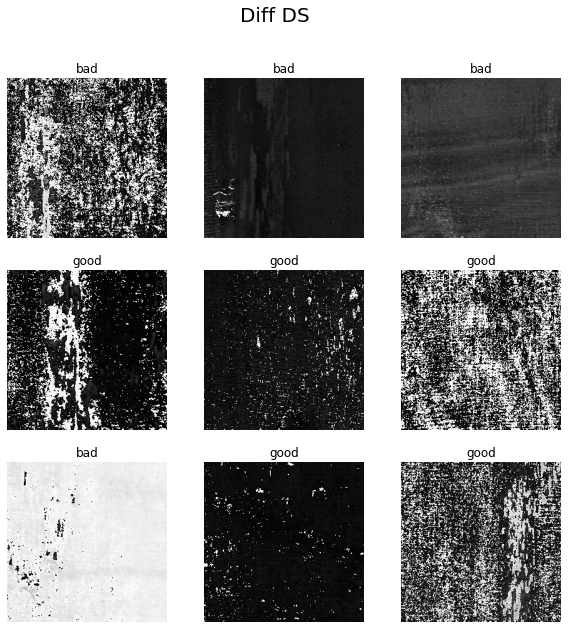

In [7]:
def plot_conv_ds(image_batch, label_batch, grayscale=False):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Diff DS', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if grayscale:
            plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = label_batch[i]
        plt.title(class_names[tf.argmax(label, axis=0)])
        plt.axis("off")

image_batch, label_batch = next(iter(diff_conv_val_ds)) 
plot_conv_ds(image_batch, label_batch, USE_GRAYSCALE)

## Classifier

In [8]:

class Classifier():
    @staticmethod
    def build(width, height, depth):
        input_shape = (height, width, depth)
        model = tf.keras.models.Sequential()
        model.add(layers.Input(shape=input_shape))
        model.add(layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1))
        model.add(layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.3, name='top_dropout'))
        model.add(layers.Dense(2, activation='softmax'))
        
        return model
        

classifier = Classifier.build(256, 256, 1 if USE_GRAYSCALE else 3)

In [9]:
opt = optimizers.Adam(lr=1e-3)
ls=losses.BinaryCrossentropy(from_logits=True)
classifier.compile(optimizer=opt, loss=ls, metrics=['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 256)     2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0

In [10]:
from datetime import datetime

timestamp = datetime.now().isoformat()
outpath = os.path.join('..', 'log', 'classifier')
def get_callbacks():
    tensorboard_dir = os.path.join(outpath, f'tensorboard')
    if not os.path.exists(tensorboard_dir):
        os.makedirs(tensorboard_dir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=1)

    metrics_dir = os.path.join(outpath, f'metrics')
    if not os.path.exists(metrics_dir):
        os.makedirs(metrics_dir)
    csv_callback = tf.keras.callbacks.CSVLogger(filename=os.path.join(metrics_dir, f'training_log_{timestamp}.csv'))

    checkpoint_dir = os.path.join(outpath, f'checkpoints')
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(verbos=0, 
        filepath=os.path.join(checkpoint_dir, 'weights.{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'),
        save_weights_only=True,
        monitor='val_loss',
        mode='auto',
        save_best_only=True,
        save_freq='epoch')

    reduce_lr_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=0.00001)

    return [tensorboard_callback, csv_callback, checkpoint_callback, reduce_lr_plateau_callback]

In [11]:
history = classifier.fit(diff_conv_train_ds,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=diff_conv_val_ds,
                shuffle=True,
                callbacks=get_callbacks())

Epoch 1/20
  1/355 [..............................] - ETA: 0s - loss: 0.7381 - accuracy: 0.1875WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
355/355 [==============================] - 56s 157ms/step - loss: 0.6536 - accuracy: 0.6983 - val_loss: 0.6521 - val_accuracy: 0.7022
Epoch 2/20
355/355 [==============================] - 55s 154ms/step - loss: 0.6532 - accuracy: 0.7001 - val_loss: 0.6521 - val_accuracy: 0.7022
Epoch 3/20
355/355 [==============================] - 55s 154ms/step - loss: 0.6535 - accuracy: 0.6995 - val_loss: 0.6521 - val_accuracy: 0.7022
Epoch 4/20
355/355 [==============================] - 55s 154ms/step - loss: 0.6555 - accuracy: 0.6953 - val_loss: 0.6521 - val_accuracy: 0.7022
Epoch 5/20
355/355 [==============================] - 54s 

<Figure size 432x288 with 0 Axes>

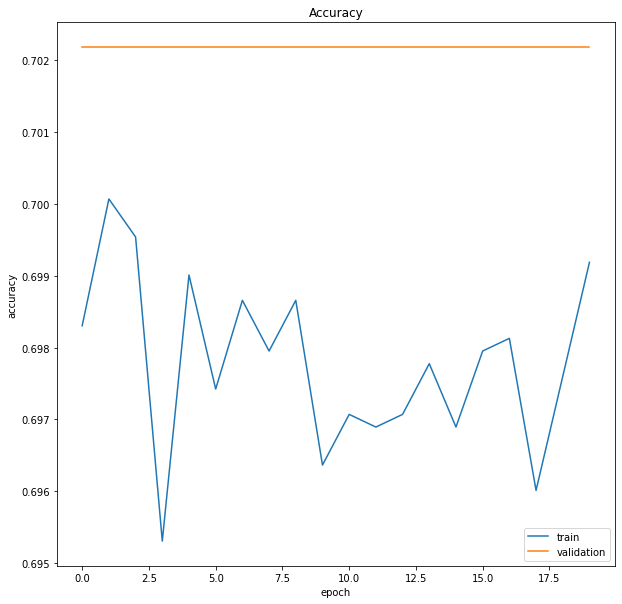

<Figure size 432x288 with 0 Axes>

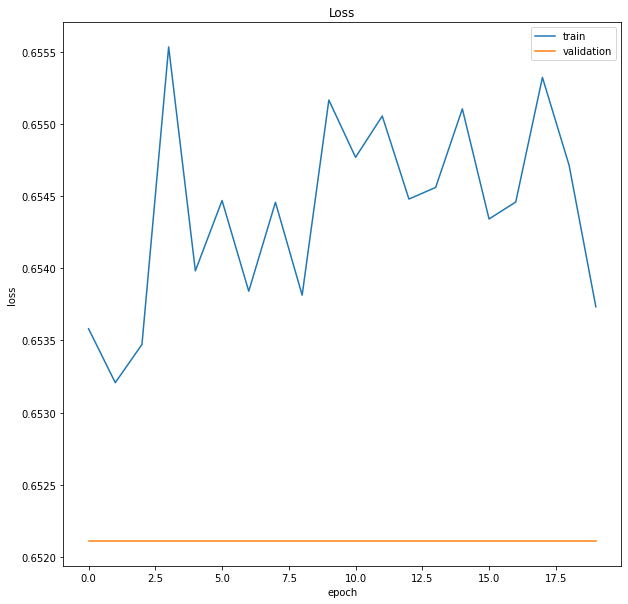

<Figure size 432x288 with 0 Axes>

In [26]:
from sklearn.metrics import confusion_matrix
plot_dir = os.path.join(outpath, f'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
def plot_accuracy(hist):
    plt.clf()
    plt.figure(figsize=(10,10))
    title = f"Accuracy"
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(title)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="lower right")
    plt.show(block=False)
    plt.savefig(os.path.join(plot_dir, f'accuracy_{timestamp}.png'))

def plot_loss(hist):
    plt.clf()
    plt.figure(figsize=(10,10))
    title = f"Loss"
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title(title)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show(block=False)
    plt.savefig(os.path.join(plot_dir, f'loss_{timestamp}.png'))
    
def plot_cm(cm):
    plt.clf()
    plt.figure(figsize=(10,10))
    total = np.sum(cm)
    tp = cm[0][0]
    fn = cm[0][1]
    fp = cm[1][0]
    tn = cm[1][1]
    tp_o = np.round((tp / total)*100,3)
    fn_o = np.round((fn / total)*100,3)
    fp_o = np.round((fp / total)*100,3)
    tn_o = np.round((tn / total)*100,3)
    tp_c = np.round(max((tp / (tp + fn)), 0.0)*100,3)
    fn_c = np.round(max((fn / (tp + fn)), 0.0)*100,3)
    fp_c = np.round(max((fp / (fp + tn)), 0.0)*100,3)
    tn_c = np.round(max((tn / (fp + tn)), 0.0)*100,3)
    labels = np.array([[
            f'TP\nCount: {tp}\nOverall: {tp_o}%\nTPR: {tp_c}%', 
            f'FN (Type 2)\nCount: {fn}\nOverall: {fn_o}%\nFNR: {fn_c}%'
        ],[
            f'FP (Type 1)\nCount: {fp}\nOverall: {fp_o}%\nFPR: {fp_c}%', 
            f'TN\nCount: {tn}\nOverall: {tn_o}%\nTNR: {tn_c}%'
        ]])
    sns.heatmap(cm, annot=labels, fmt='')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(plot_dir, f'cm_{timestamp}.png'))
    
def plot_metrics(history, metrics):
    if 'accuracy' in metrics:
        plot_accuracy(hist=history)
    if 'loss' in metrics:
        plot_loss(hist=history)
        
plot_metrics(history, ['accuracy', 'loss'])

In [13]:
model_save_dir = os.path.join(outpath, f'model')
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
classifier.save(os.path.join(model_save_dir, timestamp))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../log/classifier/model/2020-11-19T15:59:26.832242/assets


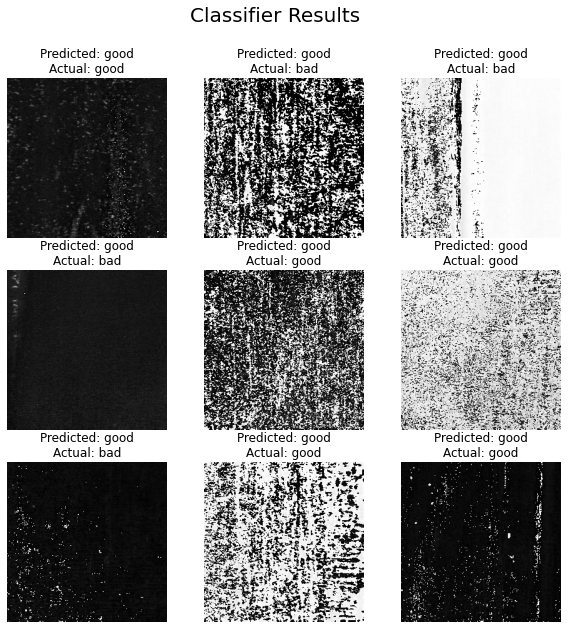

In [22]:
def plot_predictions(image_batch, predicted_label, actual_label, grayscale=False):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Classifier Results', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if grayscale:
            plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = predicted_label[i]
        label_true = actual_label[i]
        plt.title(f'Predicted: {class_names[tf.argmax(label, axis=0)]}\nActual: {class_names[tf.argmax(label_true, axis=0)]}')
        plt.axis("off")
        
evaluation_example = diff_conv_val_ds.take(1)
image_batch = None
label_batch = None
for elem in evaluation_example:
    image_batch = elem[0]
    label_batch = elem[1]
predicted_labels = classifier.predict(evaluation_example)

plot_predictions(image_batch, predicted_labels, label_batch, USE_GRAYSCALE)

In [27]:
predictions = classifier.predict(diff_conv_val_ds)
truelabels = list()
for (_, label) in diff_conv_val_ds.as_numpy_iterator():
    for l in label:
        truelabels.append(list(l))

In [31]:
#import sys
#!{sys.executable} -m pip install seaborn

     |████████████████████████████████| 283 kB 7.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


<Figure size 432x288 with 0 Axes>

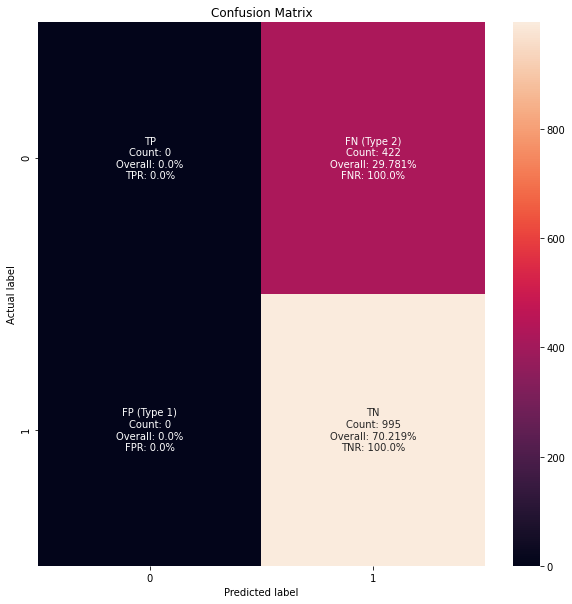

In [33]:
import seaborn as sns
plot_cm(confusion_matrix(list(map(np.argmax, truelabels)), list(map(np.argmax, predictions))))